# Plot prediction derivatives

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 4

In [2]:
assert testcase == 1 and version in [1, 2]
assert param_num <= 4

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns
import dataframe_image as dfi

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.solver_fem_1_1D import FEMSolver
from modules.utils import create_tree
from modules.fenics_expressions_1D import UexExpr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cpu


/home/flecourtier/anaconda3/envs/phifem_scimba_2/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
if version == 1:
    from modules.testcases.d1.test_1.test_1_v1 import Run_laplacian1D,Poisson_1D
elif version == 2:
    from modules.testcases.d1.test_1.test_1_v2 import Run_laplacian1D,Poisson_1D
from modules.problem_1D import TestCase1
problem = TestCase1()

result_dir = "../../results/1D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/plot/"
create_tree(result_dir)

N = 1000

/home/flecourtier/Bureau/Article1/code
torch loaded; device is cpu


init
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_1D/test_fe1.pth
network loaded
Error  tensor([0.0392])


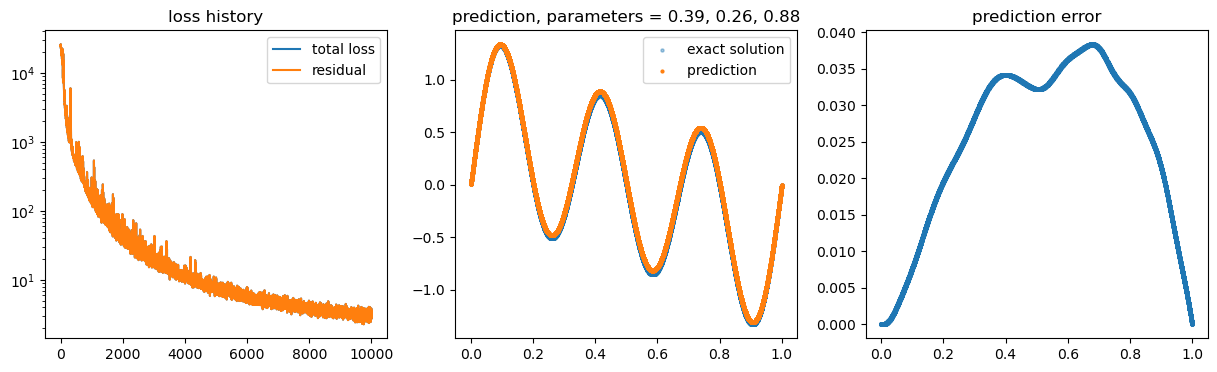

In [6]:
pde = Poisson_1D()
trainer,u_theta = Run_laplacian1D(pde)

In [7]:
test_params = [[0.3, 0.2, 0.1], [0.4, 0.6, 0.3], [0.7, 0.4, 0.6], [0.8, 0.5, 0.8]]
param = test_params[param_num-1]
print(f"param_num = {param_num}, param = {param}")
params = [param]

param_num = 4, param = [0.8, 0.5, 0.8]


In [8]:
XXYY = np.linspace(0, 1, N)
XXYY = XXYY.reshape(-1,1)

X_test = torch.tensor(XXYY,requires_grad=True)
X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

# get parameters
nb_params = len(trainer.pde.parameter_domain)
shape = (XXYY.shape[0],nb_params)
ones = torch.ones(shape)
mu_test = (torch.Tensor(params[0]).to(device) * ones).to(device)

u_ex = pde.reference_solution(X_test, mu_test).cpu().detach().numpy()
du_ex_dx = pde.reference_solution_derivative(X_test, mu_test).cpu().detach().numpy()
d2u_ex_dx2 = pde.reference_solution_second_derivative(X_test, mu_test).cpu().detach().numpy()

pred = u_theta.setup_w_dict(X_test, mu_test)
u_theta.get_first_derivatives(pred, X_test)
u_theta.get_second_derivatives(pred, X_test)
        
u_theta_ = pred["w"][:,0].cpu().detach().numpy()
u_theta_x = pred["w_x"][:,0].cpu().detach().numpy()
u_theta_xx = pred["w_xx"][:,0].cpu().detach().numpy()

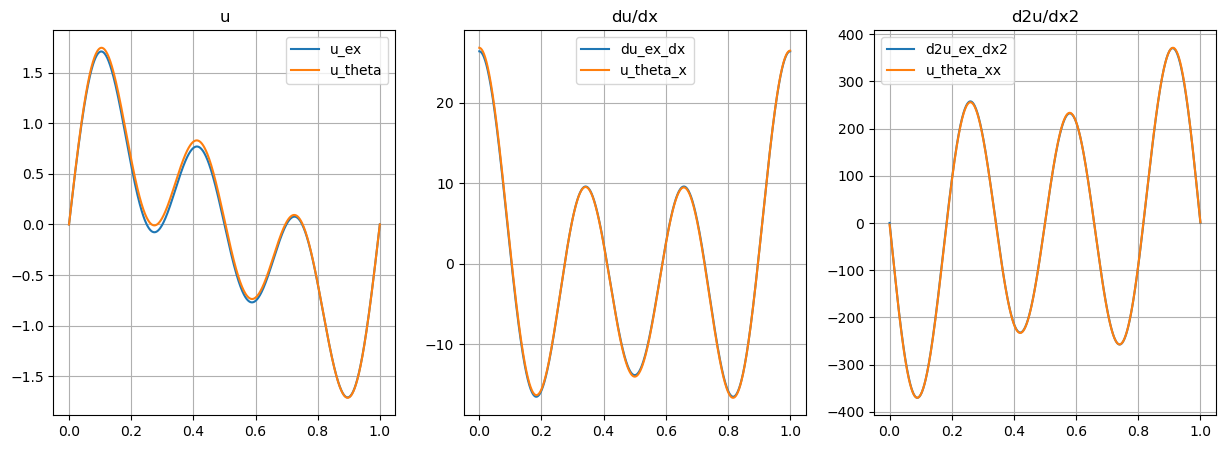

In [9]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

# plot u
axs[0].plot(XXYY, u_ex, label="u_ex")
axs[0].plot(XXYY, u_theta_, label="u_theta")
axs[0].set_title("u")

# plot du/dx
axs[1].plot(XXYY, du_ex_dx, label="du_ex_dx")
axs[1].plot(XXYY, u_theta_x, label="u_theta_x")
axs[1].set_title("du/dx")

# plot d2u/dx2
axs[2].plot(XXYY, d2u_ex_dx2, label="d2u_ex_dx2")
axs[2].plot(XXYY, u_theta_xx, label="u_theta_xx")
axs[2].set_title("d2u/dx2")

for ax in axs:
    ax.legend()
    ax.grid()

plt.savefig(result_dir+"plot_"+str(param_num)+".png")
plt.show()